In [1]:
from scipy.spatial import ConvexHull
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import copy
import numpy as np
import pickle
plt.rcParams.update({'font.size': 12})
import pandas as pd
from scipy.optimize import minimize
import csv

In [2]:
def find_closest_node_to_center(node_coords):
    # create array with IDs and coordinates
    num_nodes = node_coords.shape[0]
    node_ids = np.arange(num_nodes)
    geometry = np.column_stack((node_ids, node_coords))

    # find center of geometry
    center = np.mean(geometry[:, 1:], axis=0)
    
    # find closest node to center
    distances = np.linalg.norm(geometry[:, 1:] - center, axis=1)
    closest_node_idx = np.argmin(distances)
    closest_node_id = geometry[closest_node_idx, 0]

    return int(closest_node_id)

def poly_vert(myRVE): # Find vertices that make up the polyhedra
    n_poly = myRVE.n_poly
    poly_face_f_all = myRVE.poly_face_f_all
    face_vert_f_all = myRVE.face_vert_f_all
    verts_poly = []

    for i in range(n_poly): #Loop over polyhedrons
        #verts = [] # Vertices IDs
        verts = np.array([])
        current_poly_faces = poly_face_f_all[i]
        # let's give a max here and break if possible or do nothing 
        for j in range(len(current_poly_faces)): #Loop over faces
            current_face_vert = face_vert_f_all[int(current_poly_faces[j])-1]
            #current_face_edge = face_edge_f_all[int(current_poly_faces[j])-1]
            for m in range(len(current_face_vert)):
                verts = np.hstack((verts,current_face_vert[m]))
                
        verts_poly.append(np.unique(verts))     
           
    return verts_poly

def Vol_SA_Dist(node_pos,myRVE):
    #node_pos = jnp.array(node_pos)
    n_poly = myRVE.n_poly
    #poly_face_f_all = myRVE.poly_face_f_all
    #face_vert_f_all = myRVE.face_vert_f_all
    edge_pos = myRVE.edge_pos
    v_poly = myRVE.v_poly
    
    poly_vol = np.zeros((n_poly,1))
    poly_SA = np.zeros((n_poly,1))

    kappa = 1. # Strength of convexity constraint 
    convex = 0. # We want to keep this value equal to zero to be sure all the cells and the geometry is convex
           
    for i in range(n_poly):
        #print(v_poly)
        current_v_poly = v_poly[i]
        #print(current_v_poly)
        v_all = node_pos[current_v_poly.astype(int)-1]
        hull = ConvexHull(v_all)
        poly_vol[i] = hull.volume
        poly_SA[i] = hull.area
        if hull.vertices.size != len(v_all):
            convex += kappa  
            
    v1_coords = node_pos[edge_pos[:,0].astype(int)-1] # Coordinates of the first points
    v2_coords = node_pos[edge_pos[:,1].astype(int)-1] # Coordinates of the second points
    dist = ((v2_coords[:,0]-v1_coords[:,0])**2 + (v2_coords[:,1]-v1_coords[:,1])**2 + (v2_coords[:,2]-v1_coords[:,2])**2)**0.5
    edge_distance = dist.astype(float).reshape(-1,1)

    return poly_vol, poly_SA, edge_distance, convex

## Functions to calculate the energy
def evalPsi(node_x,myRVE):
    
    kvol = myRVE.k_vol
    karea = myRVE.k_area
    klength = myRVE.k_length
    ncell = myRVE.n_poly
    vol_ref = myRVE.vol_ref
    SA_ref = myRVE.SA_ref
    length_ref = myRVE.length_ref
    
    # compute the deformed volumes, areas and lengths 
    # Evaluate volume, surface area and edge length for each cell
    vol_def,SA_def,length_def,convex_def = Vol_SA_Dist(node_x,myRVE)
    
    # energy is going to be three components 
    #Psi_vol = kvol*np.sum((vol_def - vol_ref)**2)
    #Psi_area = karea*np.sum((SA_def - SA_ref)**2)
    #Psi_length = klength*np.sum((length_def - length_ref)**2)
    #Psi_vol = kvol*np.sum((vol_def - vol_ref)**2/vol_ref**2)/ncell
    #Psi_area = karea*np.sum((SA_def - SA_ref)**2/SA_ref**2)/ncell
    #Psi_length = klength*np.sum((length_def - length_ref)**2/length_ref**2)/len(length_ref)
    #Psi_vol = kvol*(np.sum(vol_def)/np.sum(vol_ref))**2
    #Psi_area = karea*(np.sum(SA_def)/np.sum(SA_ref))**2
    #Psi_length = klength*(np.sum(length_def)/np.sum(length_ref))**2
    Jn = vol_def/vol_ref
    Ja = SA_def/SA_ref
    Jl = length_def/length_ref
    Psi_vol = kvol*(np.mean(Jn)**2 - 2*np.mean(Jn) + 1)
    Psi_area = karea*(np.mean(Ja)**2 - 2*np.mean(Ja) + 1)
    Psi_length = klength*(np.mean(Jl)**2 - 2*np.mean(Jl) + 1)
    #print(np.mean(Jn)) #mean J
    print('Jv',np.mean(Jn)**2 - 2*np.mean(Jn) + 1) # Average J per cell
    #print(np.mean((vol_def - vol_ref)**2/vol_ref**2)) # Average J per cell which does not work
    print('Total J',(np.sum(vol_def)-np.sum(vol_ref))**2/(np.sum(vol_ref))**2) #Average total J
    
    print('Ja',(np.mean(Ja)**2 - 2*np.mean(Ja) + 1))
    print('Total A',(np.sum(SA_def)-np.sum(SA_ref))**2/(np.sum(SA_ref))**2)
    
    print('Jl',(np.mean(Jl)**2 - 2*np.mean(Jl) + 1)*klength)
    print('Total l',(np.sum(length_def)-np.sum(length_ref))**2/(np.sum(length_ref))**2)
    
    print('V',np.mean(Jn),np.sum(vol_def)/np.sum(vol_ref))
    print('A',np.mean(Ja),np.sum(SA_def)/np.sum(SA_ref))
    print('L',np.mean(Jl),np.sum(length_def)/np.sum(length_ref))
    
    return Psi_vol,Psi_area,Psi_length#+convex_def

def Dist(node_pos,myRVE):

    edge_pos = myRVE.edge_pos
        
    v1_coords = node_pos[edge_pos[:,0].astype(int)-1] # Coordinates of the first points
    v2_coords = node_pos[edge_pos[:,1].astype(int)-1] # Coordinates of the second points
    dist = ((v2_coords[:,0]-v1_coords[:,0])**2 + (v2_coords[:,1]-v1_coords[:,1])**2 + (v2_coords[:,2]-v1_coords[:,2])**2)**0.5
    edge_distance = dist.astype(float).reshape(-1,1)

    return edge_distance

## Functions to calculate the derivatives of the energy
def evaldPsidx(node_pos,myRVE):
    #node_pos = jnp.array(node_pos)
    n_poly = myRVE.n_poly
    #poly_face_f_all = myRVE.poly_face_f_all
    #face_vert_f_all = myRVE.face_vert_f_all
    edge_pos = myRVE.edge_pos
    v_poly = myRVE.v_poly
    
    poly_vol = np.zeros((n_poly,1))
    poly_SA = np.zeros((n_poly,1))

    kappa = 1. # Strength of convexity constraint 
    convex = 0. # We want to keep this value equal to zero to be sure all the cells and the geometry is convex
       
    ##---------------------------------------##
    # initialize the residual vector, three, 
    # let's do one per metric of interest
    n_node = len(node_pos)
    # note I am going to flatten it, every node has 3 coords
    # so the number of unknowns is 3*n_node 
    # the residual, just like in FE will have 3*n_node entries 
    #dvoldx = np.zeros((n_node*3)) 
    #dareadx = np.zeros((n_node*3))
    #dedgedx = np.zeros((n_node*3))
    dPsidx_vol = np.zeros((n_node,3)) 
    dPsidx_area = np.zeros((n_node,3)) 
    dPsidx_length = np.zeros((n_node,3))
    ##---------------------------------------## 
    
    kvol = myRVE.k_vol
    karea = myRVE.k_area
    klength = myRVE.k_length
    vol_ref = myRVE.vol_ref
    SA_ref = myRVE.SA_ref
    length_ref = myRVE.length_ref
    #print(kvol,karea,klength)
    
    for i in range(n_poly):
        current_v_poly = v_poly[i]
        #print(current_v_poly)
        v_all = node_pos[current_v_poly.astype(int)-1]
        hull = ConvexHull(v_all)
        poly_vol[i] = hull.volume
        poly_SA[i] = hull.area
        if hull.vertices.size != len(v_all):
            convex += kappa  
        ###### PROF. CODE
        eps = 1e-6
        for ni in range(len(v_all)):
            global_node_ni = current_v_poly[ni].astype(int)-1
            # loop over coordinate
            for ci in range(3):
                # some variations for central difference
                v_all[ni,ci] += eps
                # this is the change in volume by moving the node by a little bit
                # namely f(x+eps,y) where y represents all other nodal values which stay constant
                hull_p_nici = ConvexHull(v_all)
                # for central difference 
                v_all[ni,ci] -= eps
                # apply finite difference scheme
                # use the change in volume to get derivative 
                dpsivoldnici = 2*kvol*(poly_vol[i]-vol_ref[i])*(hull_p_nici.volume - poly_vol[i])/(eps)
                # this is the change in area
                dpsiareadnici = 2*karea*(poly_SA[i]-SA_ref[i])*(hull_p_nici.area  - poly_SA[i])/(eps)
                # now, the thing is how to assing this to the GLOBAL node 
                # add to residual since the derivative from multiple polyhedra can add to the
                # same nodal entry
                # JACQUES: you need to know what is the global index of the node
                # see how we are moving node 'ni' of v_all, but what node is that in the
                # node_pos array? 
                dPsidx_vol[global_node_ni,ci] += dpsivoldnici
                dPsidx_area[global_node_ni,ci] += dpsiareadnici 
        # MY CODE. I can get away with this since a shift on the hull does not change the volume or area
        #eps = 1e-6
        #global_node_ni = current_v_poly.astype(int)-1
        #dPsidx_vol[global_node_ni,:] += 2*kvol*(poly_vol[i]-vol_ref[i])*(poly_vol[i] - poly_vol[i])/(eps)
        #dPsidx_area[global_node_ni,:] += 2*karea*(poly_SA[i]-SA_ref[i])*(poly_SA[i]  - poly_SA[i])/(eps)
        
             
    edge_distance = Dist(node_pos,myRVE)
                              
    dPsi_dlength = 2.*klength*(edge_distance - length_ref)*(node_pos[edge_pos[:,1].astype(int)-1] - node_pos[edge_pos[:,0].astype(int)-1])/edge_distance 
    for ni in range(len(edge_distance)):
        n1 = edge_pos[ni,0].astype(int)-1
        n2 = edge_pos[ni,1].astype(int)-1
        dPsidx_length[n1,:] -= dPsi_dlength[ni,:]
        dPsidx_length[n2,:] += dPsi_dlength[ni,:]
    #n1 = edge_pos[:,0].astype(int)-1
    #n2 = edge_pos[:,1].astype(int)-1
    #dPsidx_length[n1,:] -= dPsi_dlength
    #dPsidx_length[n2,:] += dPsi_dlength

    #Psidx_length = 0.
    return dPsidx_vol, dPsidx_area, dPsidx_length

def calcBCforce(node_def,myRVE,stretch,beta):
    ## force vector for boundary conditions 
    BC_forces = np.zeros((len(node_def),3))
    # over-write the position of the nodes that we can apply BC to 
    PBC_penalty = 0
    #beta = 10000 # penalty to try to enforce the constraint 
    #dPBC = [0.01,0.01,0.01] # the displacements we want to apply 
    l0_vec = np.array([0.3,0.6]) # RVE length
    l0 = l0_vec[RVE_N]
    dPBC = np.array([1,1,1])*(l0*stretch-l0) # the displacements we want to apply 
    BC_pair = myRVE.vert_pair
    n_BC = len(BC_pair)
    for i in range(n_BC):
        n2 = int(BC_pair[i,0])-1
        n1 = int(BC_pair[i,1])-1
        #print(node_x[n2,1]-node_x[n1,1])
        for j in range(3):
            # I dont think this is correct
            #PBC_penalty += beta*((node_x[n2,j]-node_x[n1,j])-(dPBC[j] + l0)*BC_pair[i,j+2])**2
            BC_forces[n1,j] += -2*beta*((node_def[n2,j]-node_def[n1,j])-(dPBC[j] + l0)*BC_pair[i,j+2])
            BC_forces[n2,j] += +2*beta*((node_def[n2,j]-node_def[n1,j])-(dPBC[j] + l0)*BC_pair[i,j+2])
    #print(BC_forces)
            
    #n2 = BC_pair[:,0].astype(int)-1
    #n1 = BC_pair[:,1].astype(int)-1

    # calculate the BC forces using arrays instead of a loop
    #BC_forces[n1,:] -= 2*beta*((node_def[n2,:]-node_def[n1,:])-(dPBC + l0)*BC_pair[:,2:5])
    #BC_forces[n2,:] += 2*beta*((node_def[n2,:]-node_def[n1,:])-(dPBC + l0)*BC_pair[:,2:5])
            
    return BC_forces


In [3]:
# Load the CSV file using loadtxt
data = np.loadtxt('/scratch/brown/jbarsima/RVE/RVE_adip_size/tess_files/samples.csv', delimiter=',')
#data = data.transpose()
D = data[:,0]
Dstd = data[:,1]
S = data[:,2]
Sstd = data[:,3]

In [4]:
nodes_all_fin = []
Psi_all = []
Psi_vol_all = []
Psi_area_all = []
Psi_length_all = []
Dc = []
Dstdc = []
Sc = []
Sstdc = []
vol_all = []
iii = 0

for RVE_N in range(0,1):
    NN = str(RVE_N+1)
    print('RVE',NN)
    file = '/scratch/brown/jbarsima/RVE/RVE_adip_size/tess_files/RVE_'+ NN +'x.tess'
    #file = 'RVE_2.tess'
    data = []
    with open(file, 'r') as f:
        for line in f:
            line_data = line.strip().split()
            # append the data from this line to the list
            data.append(line_data)

    ## VERTEX DATA
    # loop through each element of the 'data' list
    for i in range(len(data)):
        # check if the current element matches the search value
        if data[i] == ['**vertex']:
            #print(f"Found '**vertex' at index {i}.")
            vertex_in = i #Index for vertex
            break

    n_vertex = int(data[vertex_in + 1][0]) #Number of vertices

    node_ref = np.zeros((1,3))
    for i in range(n_vertex):
        ii = i + vertex_in + 2
        x = float(data[ii][1])
        y = float(data[ii][2])
        z = float(data[ii][3])
        temp = np.array([x,y,z])
        node_ref = np.vstack((node_ref,temp))
    node_ref = node_ref[1:,:] #Vertices

    ## EDGE DATA
    # loop through each element of the 'data' list
    for i in range(n_vertex,len(data)):
        # check if the current element matches the search value
        if data[i] == ['**edge']:
            #print(f"Found '**edge' at index {i}.")
            edge_in = i #Index for edge

    n_edge = int(data[edge_in + 1][0]) #Number of edges

    edge_pos = np.zeros((1,2))
    for i in range(n_edge):
        ii = i + edge_in + 2
        ini_ = int(data[ii][1])
        end_ = int(data[ii][2])
        temp = np.array([ini_,end_])
        edge_pos = np.vstack((edge_pos,temp))
    edge_pos = edge_pos[1:,:] #edges

    ## FACE DATA
    # loop through each element of the 'data' list
    for i in range(n_edge + edge_in,len(data)):
        # check if the current element matches the search value
        if data[i] == ['**face']:
            #print(f"Found '**face' at index {i}.")
            face_in = i #Index for face
            break

    n_face = int(data[face_in + 1][0]) #Number of faces

    off = 2
    face_vert_f_all = []
    face_edge_f_all = []
    for i in range(n_face):
        ii = 4*i + face_in + off
        face_vert = data[ii] #Vertices that form the face
        face_edge = data[ii+1] #Edges that form the face
        face_vert_f = [] #Float
        face_edge_f = [] #Float
        for j in range(len(face_vert)):
            face_vert_f.append(float(face_vert[j]))
        face_vert_f = np.abs(face_vert_f[2:])
        # Array that containts all the vertices for the faces. Useful to find volume without
        # having to index edges
        face_vert_f_all.append(face_vert_f) 
        for m in range(len(face_edge)):
            face_edge_f.append(float(face_edge[m]))
        face_edge_f = np.abs(face_edge_f[1:])
        # Array that containts all the edges for the faces
        # Note that this has "the same" data as face_vert_f_all but 
        # with edge information instead of vertex information directly.
        # This one can be used to create a mesh as it lists the node
        # connectivity by edge. They are ordered correctly so they can be indexed.
        # For example, face 4 contains edges [4. 25. 26. 15. 27. 28.] which have nodes
        # [8. 2. 4. 1. 14. 15.], in that order. These edges can be used to index
        # the array edge_pos. For example, edge_pos[3] will give the nodes that make up
        # edge 4 (8 2). Then, using this data, one can index node_ref to obtain the coordinates
        # of the vertex. THIS PARTICULAR NUMBERS WERE OBTAINED FROM RVE_2
        face_edge_f_all.append(face_edge_f) 
    #print(face_edge_f_all[3])
    #print(face_vert_f_all[3])
    #print(edge_pos[3])
    #print(node_ref[7])

    ## POLYHEDRON DATA
    # loop through each element of the 'data' list
    for i in range(n_face + face_in,len(data)):
        # check if the current element matches the search value
        if data[i] == ['**polyhedron']:
            #print(f"Found '**polyhedron' at index {i}.")
            poly_in = i #Index for face
            break

    n_poly = int(data[poly_in + 1][0]) #Number of polyhedrons
    
    if n_poly >= 3000:
        print('Too many cells')
        continue

    poly_face_f_all = []
    for i in range(n_poly):
        ii = i + poly_in + 2
        poly_face = data[ii] #Faces that form the poly
        poly_face_f = [] #Float
        for j in range(len(poly_face)):
            poly_face_f.append(float(poly_face[j]))
        poly_face_f = np.abs(poly_face_f[2:]) 
        poly_face_f_all.append(poly_face_f) #Array that containts all the faces
    #print(poly_face_f_all)

    ##############################################################
    ## PERIODICITY INFO
    ## PERIODICITY SECTION INDEX
    # loop through each element of the 'data' list
    for i in range(n_poly + poly_in,len(data)):
        # check if the current element matches the search value
        if data[i] == ['**periodicity']:
            #print(f"Found '**periodicity' at index {i}.")
            periodicity_in = i #Index for periodicity section
            break

    ## VERTEX INFO
    # loop through each element of the 'data' list
    for i in range(periodicity_in,len(data)):
        # check if the current element matches the search value
        if data[i] == ['*vertex']:
            #print(f"Found '*vertex' at index {i}.")
            vertex_per_in = i #Index for periodicity section
            break
    n_vertex_per = int(data[vertex_per_in + 1][0]) #Number of periodic vertices

    vert_pair = np.zeros((n_vertex_per,5)) # <secondary_ver_id> <primary_ver_id> <per_shift_x> <per_shift_y> <per_shift_z>
    vert_pair_coord = np.zeros((1,3)) # Coordinates of the periodic vertices. Twice the length of vert_pair always
    # Ordered as <secondary_ver_coords> in the 2n row, <primary_ver_coords> in the 2n+1 row. n = 0,1,2,...
    for i in range(n_vertex_per):
        ii = i + vertex_per_in + 2
        vert_pair_temp = data[ii]  
        vert_pair[i,0] = vert_pair_temp[0] #Secondary vertex
        vert_pair[i,1] = vert_pair_temp[1] #Primary vertex
        vert_pair[i,2] = vert_pair_temp[2] #Periodic shift x
        vert_pair[i,3] = vert_pair_temp[3] #Periodic shift y
        vert_pair[i,4] = vert_pair_temp[4] #Periodic shift z
        #print(vert_pair_temp)
        vert_pair_coord = np.vstack((vert_pair_coord,node_ref[int(vert_pair[i,0])-1]))
        vert_pair_coord = np.vstack((vert_pair_coord,node_ref[int(vert_pair[i,1])-1]))
    vert_pair_coord = vert_pair_coord[1:,:]
    #print(len(vert_pair_coord))

    ## EDGE INFO
    # loop through each element of the 'data' list
    for i in range(n_vertex_per + vertex_per_in,len(data)):
        # check if the current element matches the search value
        if data[i] == ['*edge']:
            #print(f"Found '*edge' at index {i}.")
            edge_per_in = i #Index for periodicity section
            break
    n_edge_per = int(data[edge_per_in + 1][0]) #Number of periodict vertices

    edge_pair = np.zeros((n_edge_per,2)) # Pair of periodic edges
    for i in range(n_edge_per):
        ii = i + edge_per_in + 2
        edge_pair_temp = data[ii] 
        edge_pair[i,0] = edge_pair_temp[0]
        edge_pair[i,1] = edge_pair_temp[1]
        #print(edge_pair_temp)
    #print(edge_pair)   

    ## FACE INFO
    # loop through each element of the 'data' list
    for i in range(n_edge_per + edge_per_in,len(data)):
        # check if the current element matches the search value
        if data[i] == ['*face']:
            #print(f"Found '*face' at index {i}.")
            face_per_in = i #Index for periodicity section
            break
    n_face_per = int(data[face_per_in + 1][0]) #Number of periodic faces

    face_pair = np.zeros((n_face_per,2)) # Pair of periodic faces
    for i in range(n_face_per):
        ii = i + face_per_in + 2
        face_pair_temp = data[ii]
        face_pair[i,0] = face_pair_temp[0]
        face_pair[i,1] = face_pair_temp[1]
        #print(face_pair_temp)
    #print(face_pair)  

    #Find the closest node to the center of the geometry
    ID_center = find_closest_node_to_center(node_ref)

    # initial guess for deformed RVE is just the original RVE 
    node_def = copy.deepcopy((node_ref))

    ## trying to create a hashable object 
    class RVE:
        def __init__(self,n_poly,poly_face_f_all,face_vert_f_all,face_edge_f_all,edge_pos,node_ref,vert_pair,ID_center,n_edge):
            self.n_poly = n_poly
            self.poly_face_f_all = poly_face_f_all
            self.face_vert_f_all = face_vert_f_all
            self.face_edge_f_all = face_edge_f_all
            self.edge_pos = edge_pos
            self.node_ref = node_ref
            self.vert_pair = vert_pair
            self.ID_center = ID_center
            self.n_edge = n_edge
            self.v_poly = 0. #Dummy variable for until we find the actual value
            self.k_vol = 1.
            self.k_area = 1.
            self.k_length = 1.
            self.vol_ref = 1.
            self.SA_ref = 1.
            self.length_ref = 1.

    myRVE = RVE(n_poly,poly_face_f_all,face_vert_f_all,face_edge_f_all,edge_pos,node_ref,vert_pair,ID_center,n_edge)
    hash(myRVE)

    poly_v = poly_vert(myRVE)
    myRVE.v_poly = poly_v # Replace dummy variable for actual value

    # Evaluate volume, surface area and edge length for each cell
    # We need to run this line in order to obtain the values for the reference configuration
    # Here I am using the Vol_SA_Dist on purpose to find the reference volume, SA, etc. quickly
    # as it is needed later.
    vol_ref,SA_ref,length_ref,convex_ref = Vol_SA_Dist(node_ref,myRVE)
    myRVE.vol_ref = vol_ref
    myRVE.SA_ref = SA_ref
    myRVE.length_ref = length_ref

    node_def = copy.deepcopy((node_ref))

    #myRVE.k_vol = 0.01531663075071653
    #myRVE.k_area = 2.009900014873474
    #myRVE.k_length = 1.0001975079890093
    myRVE.k_vol = 0.0022311361146344173
    myRVE.k_area = 0.22694001547540468
    myRVE.k_length = 0.493591321443743
    #myRVE.k_vol = 1.0
    #myRVE.k_area = 2.0
    #myRVE.k_length = 0.09
    dt = 0.0015
    tol =  1e-5
    err = 10
    err_old = 20
    it = 0
    conv_it = 0
    
    if len(vol_ref) >= 2500:
        itmax = int(200)
    elif len(vol_ref) >= 1000:
        itmax = int(275)
    else:
        itmax = int(600)
        
    print('itmax:', itmax, 'Cells:', n_poly)
    itmax = 25 #Setting it to 25 since we dont neet that many iterations for debuggin.
    while err > tol and it < itmax:
        dPsisV,dPsisA,dPsisL = evaldPsidx(node_def,myRVE)
        BC_forces = calcBCforce(node_def,myRVE,1.3,100.)
        step = -dPsisV -dPsisA -dPsisL - BC_forces
        err = np.linalg.norm(dt*(step))
        if err > err_old and it > 0:
            dt -= 0.0005
            print('Decreased time step')
            if dt <= 0:
                print('Did not converge!',dt)
                conv_it = 1
                break
        else:
            node_def += dt*(step)
            err_old = copy.deepcopy(err)
        if ((it+1) % 275) == 0 or it == 0 or (it+1) == itmax: 
            print('it:', it+1, 'dt:', dt,'error:', err)
        it += 1
    if conv_it == 0:
        vol_fin,SA_fin,length_fin,convex_fin = Vol_SA_Dist(node_def,myRVE)
        #print(convex_fin)
        Psi_fin_vol,Psi_fin_area,Psi_fin_length = evalPsi(node_def,myRVE)
        Psi_vol_all.append(Psi_fin_vol)
        Psi_area_all.append(Psi_fin_area)
        Psi_length_all.append(Psi_fin_length)
        Psi_all.append(Psi_fin_vol+Psi_fin_area+Psi_fin_length)
        nodes_all_fin.append(node_def)
        vol_all.append(np.sum(vol_fin))
        Dc.append(D[RVE_N])
        Dstdc.append(Dstd[RVE_N])
        Sc.append(S[RVE_N])
        Sstdc.append(Sstd[RVE_N])

        with open('RVE_Psi_size.csv', 'a', newline='') as csvfile:
            writer = csv.writer(csvfile)
            #writer.writerow(['D', 'Dstd', 'S', 'Sstd','Psi'])
            #for i in range(len(Dc)):
            writer.writerow([Dc[iii], Dstdc[iii], Sc[iii], Sstdc[iii],Psi_all[iii],Psi_vol_all[iii],Psi_area_all[iii],Psi_length_all[iii],vol_all[iii]])  
        
        iii += 1

RVE 1
itmax: 600 Cells: 231
it: 1 dt: 0.0015 error: 1.2116955063051116
it: 25 dt: 0.0015 error: 0.001769180579834211
Jv 1.9387326839749965
Total J 1.9929140325449786
Ja 0.5424978522457655
Total A 0.5511730637311052
Jl 0.7509510470779781
Total l 0.09945947812249771
V 2.39238381345626 2.411706071583238
A 1.736544535140792 1.7424103068594248
L 2.2334514391349662 1.3153719678768196


In [5]:
print(Psi_fin_vol,Psi_fin_area,Psi_fin_length)

0.00432557650783873 0.12311447098402784 0.7509510470779781


In [6]:
(np.sum(vol_fin)/np.sum(vol_ref))

2.411706071583238

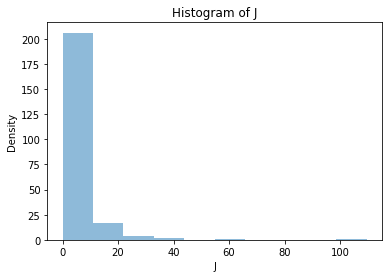

In [7]:
data = (vol_fin/vol_ref-1)**2
# Create the histogram
plt.hist(data, alpha=0.5)

# Add labels and title
plt.xlabel('J')
plt.ylabel('Density')
plt.title('Histogram of J')

# Show the plot
plt.show()

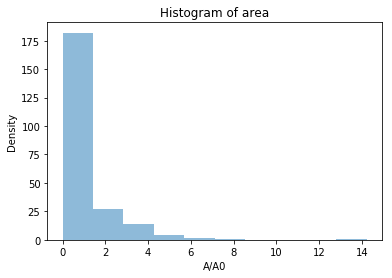

In [8]:
data = (SA_fin/SA_ref-1)**2
# Create the histogram
plt.hist(data, alpha=0.5)

# Add labels and title
plt.xlabel('A/A0')
plt.ylabel('Density')
plt.title('Histogram of area')

# Show the plot
plt.show()

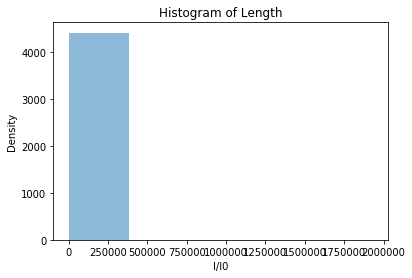

In [9]:
data = (length_fin/length_ref-1)**2

# Create the histogram
plt.hist(data,bins = 5,alpha=0.5)

# Add labels and title
plt.xlabel('l/l0')
plt.ylabel('Density')
plt.title('Histogram of Length')

# Show the plot
plt.show()